# Timeseries Forecasting of Cryptocurrency Prices

In this exploration, I make an attempt to train recurrent neural networks to predict the price of cryptocurrencies such as bitcoin.

## Importing Libraries and Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/LTC USD Historical Data.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 10, 2018",248.500,246.900,249.670,232.520,456.61K,0.69
1,"Jan 09, 2018",246.790,255.210,258.750,238.750,404.78K,-3.35
2,"Jan 08, 2018",255.350,272.080,273.670,231.640,590.53K,-6.14
3,"Jan 07, 2018",272.060,279.420,286.950,265.240,355.27K,-2.63
4,"Jan 06, 2018",279.420,246.230,304.000,245.000,797.57K,13.48


In [3]:
data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
502,"Aug 26, 2016",3.810,3.810,3.900,3.770,3.34K,0.00
503,"Aug 25, 2016",3.810,3.840,3.880,3.750,5.09K,-0.78
504,"Aug 24, 2016",3.840,3.950,3.960,3.610,5.08K,-2.78
505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506,NaN,Highest:420.000,Lowest:3.260,Difference:416.740,Average:42.324,"Change %:6,191.139",NaN


In [4]:
data.dropna(axis=0, inplace=True)
data = data.iloc[::-1]

In [5]:
from pandas import datetime
data['Date'] = data['Date'].apply(lambda date: pd.to_datetime(date))

In [6]:
import locale
from locale import *
locale.setlocale(locale.LC_NUMERIC, '')
data['Price'] = data['Price'].apply(lambda x: atof(x))

In [7]:
data['Open'] = data['Open'].apply(lambda x: atof(x))
data['High'] = data['High'].apply(lambda x: atof(x))
data['Low'] = data['Low'].apply(lambda x: atof(x))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 504 to 0
Data columns (total 7 columns):
Date        505 non-null datetime64[ns]
Price       505 non-null float64
Open        505 non-null float64
High        505 non-null float64
Low         505 non-null float64
Vol.        505 non-null object
Change %    505 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 31.6+ KB


## Visualizing prices for the whole dataset

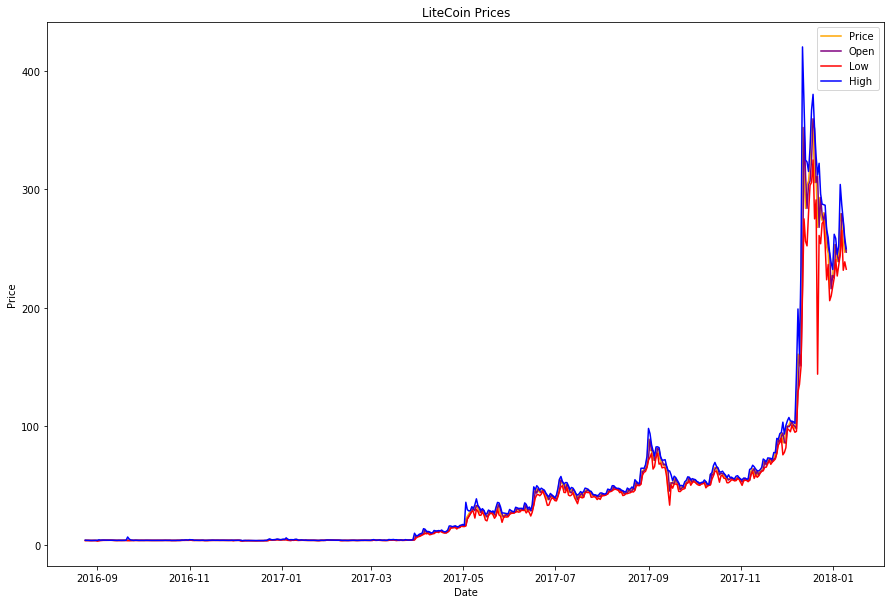

In [9]:
plt.plot(data['Date'], data['Price'], color = 'orange')
plt.plot(data['Date'], data['Open'], color='purple')
plt.plot(data['Date'], data['Low'], color='red')
plt.plot(data['Date'], data['High'], color='blue')
plt.title('LiteCoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

## Using TensorFlow to Train RNNs

In [10]:
import tensorflow as tf

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [11]:
data = data.set_index('Date')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2016-08-24 to 2018-01-10
Data columns (total 6 columns):
Price       505 non-null float64
Open        505 non-null float64
High        505 non-null float64
Low         505 non-null float64
Vol.        505 non-null object
Change %    505 non-null float64
dtypes: float64(5), object(1)
memory usage: 27.6+ KB


### Scaling the Data
In order to train a neural network on this data, it is a good idea to scale it first.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
price_data_scaled = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

### Creating a Dataset with Features

In [16]:
def create_dataset(timeseries, n_inputs=30):
    
    features = []
    targets = []
    
    for i in range(len(timeseries) - n_inputs):
        
        start = i
        end = start + n_inputs
        
        x = timeseries[start:end]
        y = timeseries[end]
        
        features.append(x)
        targets.append(y)
    
    return np.array(features), np.array(targets)

In [17]:
X, y = create_dataset(price_data_scaled, n_inputs=14)

In [18]:
X.shape

(491, 14, 1)

In [19]:
percent_training = 0.75
num_samples = X.shape[0]
num_train = int(percent_training * num_samples)

X_train, y_train = X[:num_train], y[:num_train]
X_test, y_test = X[num_train:], y[num_train:]

## Training the RNN Model

In [20]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

num_inputs = 14

model = Sequential()
model.add(LSTM(100, input_shape=(num_inputs, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

Using TensorFlow backend.


In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=1, epochs=100, callbacks=[early_stopping])

Train on 368 samples, validate on 123 samples
Epoch 1/100
368/368 [==============================] - 4s 10ms/step - loss: 3.3707e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0103 - val_mean_absolute_error: 0.0519
Epoch 2/100
368/368 [==============================] - 3s 8ms/step - loss: 1.6305e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0059 - val_mean_absolute_error: 0.0418
Epoch 3/100
368/368 [==============================] - 3s 9ms/step - loss: 1.2074e-04 - mean_absolute_error: 0.0070 - val_loss: 0.0048 - val_mean_absolute_error: 0.0320
Epoch 4/100
368/368 [==============================] - 3s 8ms/step - loss: 9.3953e-05 - mean_absolute_error: 0.0061 - val_loss: 0.0242 - val_mean_absolute_error: 0.1182
Epoch 5/100
368/368 [==============================] - 3s 8ms/step - loss: 9.4372e-05 - mean_absolute_error: 0.0060 - val_loss: 0.0036 - val_mean_absolute_error: 0.0267
Epoch 6/100
368/368 [==============================] - 3s 8ms/step - loss: 8.3470e-05 - mean_absolute_error:

In [22]:
model.save('./models/litecoin_model.h5')

### Comparing Generated Predictions with Prices in Testing Set

In [23]:
pred = model.predict(X_test)

In [24]:
pred.shape

(123, 1)

In [25]:
results = scaler.inverse_transform(pred)

In [26]:
num_samples = results.shape[0]
test_data_price = data.iloc[-num_samples:]['Price']

In [27]:
test_data_price_pred = pd.DataFrame({'Date': test_data_price.index, 
                                     'Price': test_data_price.values, 
                                     'Prediction': results[:, 0]})

In [28]:
test_data_price_pred

,Date,Prediction,Price
0,2017-09-10,72.872673,67.44
1,2017-09-11,68.948059,68.28
2,2017-09-12,69.694160,66.00
3,2017-09-13,67.114174,61.80
4,2017-09-14,63.307068,45.42
5,2017-09-15,47.841251,52.29
6,2017-09-16,54.709522,52.47
7,2017-09-17,53.073421,51.37
8,2017-09-18,52.399853,56.30
9,2017-09-19,57.343075,52.95


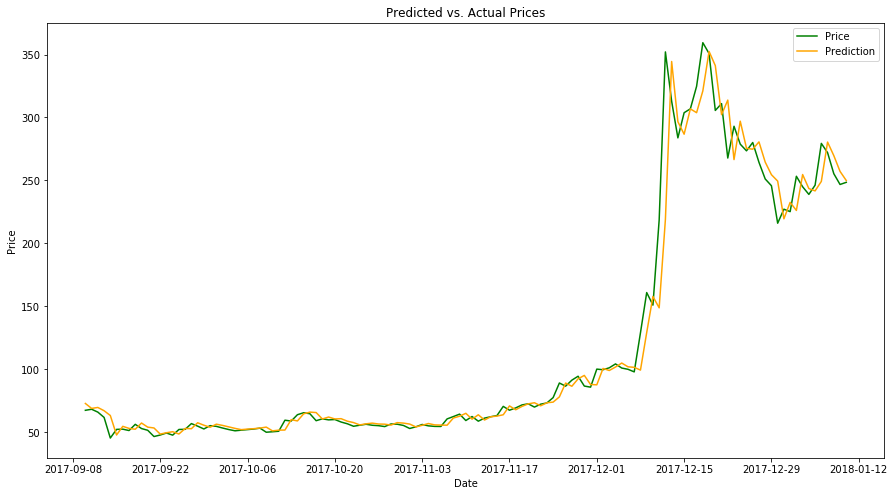

In [29]:
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Price'], color='green')
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Prediction'], color='orange')
plt.legend()
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
fig = plt.gcf()
fig.set_size_inches(15, 8)